In [1]:
import cv2 as cv
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def show_image(image):
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()

## Zadanie 1 Analiza Obrazów

In [3]:
def invert_img(img_g):
     inv_img = (255-img_g)
     return inv_img

In [4]:
def get_correlation(img, img_pattern):
    return np.real(np.fft.ifft2(np.multiply(np.fft.fft2(img), np.fft.fft2(np.rot90(img_pattern, 2), img.shape))))

In [5]:
def find_patterns(C, img, img_pattern, percentage):
    peak = np.amax(C)
    threshold = percentage * peak
    pattern_matched = np.zeros(C.shape)
    cnt = 0
    for i in range(img_pattern.shape[0], img.shape[0]):
        for j in range(img_pattern.shape[1], img.shape[1]):
            if C[i, j] > threshold:
                pattern_matched[i-img_pattern.shape[0]:i, j-img_pattern.shape[1]:j] = C[i, j]
                cnt += 1
    return pattern_matched, cnt

In [6]:
def mark_patterns_gray(found_patterns, img):
    color_match = cv.cvtColor(np.float32(found_patterns), cv.COLOR_GRAY2BGR)
    color_img = cv.cvtColor(img,cv.COLOR_GRAY2RGB)
    color_match *= [0, 0, 1]
    marked_img = color_img + color_match
    return marked_img

In [7]:
galia = cv.imread('galia.png', 0)
e_pattern = cv.imread('galia_e.png', 0)
galia_inv = invert_img(galia)
e_pattern_inv = invert_img(e_pattern)

In [8]:
C_galia = get_correlation(galia_inv, e_pattern_inv)
matches_galia, cnt_of_e = find_patterns(C_galia, galia_inv, e_pattern_inv, 0.95)
e_on_text = mark_patterns_gray(matches_galia, galia)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3403085.0].


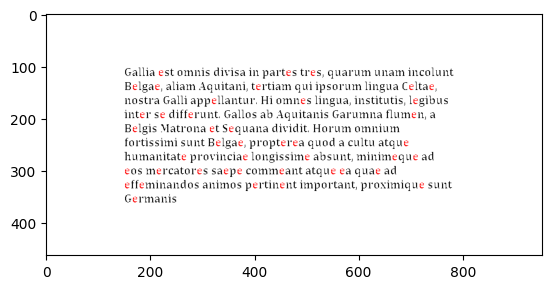

znalezionych dopasowań wzorca: 43


In [9]:
show_image(e_on_text)
print(f"znalezionych dopasowań wzorca: {cnt_of_e}")
cv.imshow("img1", e_on_text)
cv.waitKey(10000)
cv.destroyAllWindows()

In [7]:
def mark_patterns_color(found_patterns, img):

    if found_patterns.max() > 1.0:
        found_patterns_norm = found_patterns / found_patterns.max()
    else:
        found_patterns_norm = found_patterns.copy()
    
    color_match = cv.cvtColor(np.float32(found_patterns_norm), cv.COLOR_GRAY2BGR)
    
    color_match *= [0, 0, 1]
    
    if img.dtype == np.uint8:
        img_float = img.astype(np.float32) / 255.0
    else:
        img_float = img.astype(np.float32)
        if img_float.max() > 1.0:
            img_float = img_float / 255.0
    
    marked_img = img_float + color_match
    
    marked_img = np.clip(marked_img, 0, 1)
    
    if img.dtype == np.uint8:
        marked_img = (marked_img * 255).astype(np.uint8)
        
    return marked_img

In [8]:
def find_fish(C, img, img_pattern, percentage):
    peak = np.amax(C)
    threshold = percentage * peak
    pattern_matched = np.zeros(C.shape)
    cnt = 0
    for i in range(img_pattern.shape[0], img.shape[0]):
        for j in range(img_pattern.shape[1], img.shape[1]):
            if C[i, j] > threshold:
                pattern_matched[i, j] = C[i, j]
                cnt += 1
    return pattern_matched, cnt

In [12]:
school = cv.imread('school.jpg', 0)
school_color = cv.imread('school.jpg', 1)
fish_pattern = cv.imread('fish1.png', 0)

In [13]:
C_school = get_correlation(school, fish_pattern)
# matches_school, cnt_of_fish = find_patterns(C_school, school, fish_pattern, 0.65)
matches_school, cnt_of_fish = find_fish(C_school, school, fish_pattern, 0.6)
fish_on_school = mark_patterns_color(matches_school, school_color)

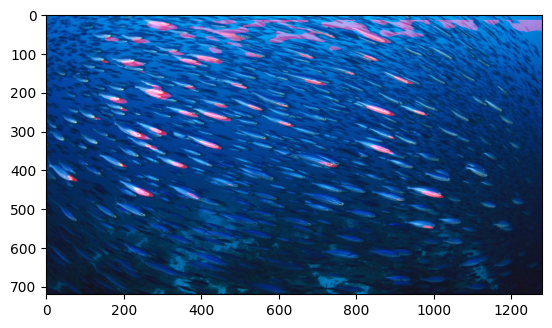

znalezionych dopasowań wzorca: 36752


In [14]:
show_image(fish_on_school)
print(f"znalezionych dopasowań wzorca: {cnt_of_fish}")
cv.imshow("img2", fish_on_school)
cv.waitKey(10000)
cv.destroyAllWindows()

## Zadanie 2 OCR

### Text Image Generation
This function renders a given text string into an image by assembling individual character images. Optionally, the entire image can be rotated by a given angle.

In [9]:
from generate_image import generate_text_image

### Deskewing the image
This approach deskews an image by rotating it across a range of angles and selecting the one with the highest horizontal energy, measured as the variance of summed pixel values across rows. Higher variance indicates better horizontal alignment of text. The best angle is used to rotate the original image, and the energy curve is visualized.

Another tested method (that turned out to be inaccurate) was to take the DFT of an image and do a "radar sweep" to find which angle has the greatest sum of frequency amplitudes along the line (as described [here](https://dsp.stackexchange.com/questions/32420/finding-an-images-orientation-with-dft-frequency-amplitudes)).

A more efficient (while still accurate) approach would be to use the Hough transform to detect most relevant lines in the image.

In [10]:
from deskew import deskew_direct
# TODO: implement deskewing using Hough transform

In [11]:
def combine_images(main_image, appended_image, on_top=False, background=255):
    # Determine the maximum width
    width = max(main_image.width, appended_image.width)
    height = main_image.height + appended_image.height

    # Create a new result image
    result = Image.new("L", (width, height), color=background)

    # Paste images aligned to the left
    if on_top:
        result.paste(appended_image, (0, 0))
        result.paste(main_image, (0, appended_image.height))
    else:
        result.paste(main_image, (0, 0))
        result.paste(appended_image, (0, main_image.height))

    return result


### Coloring Matched Letters
Once a pattern is detected, we delete a rectangle of the same dimensions to prevent visually similar letters (such as “n” and “m”) from being matched again.

In [12]:
def color_matched_letters(found_patterns, image, pattern):
    height = pattern.shape[0]
    width = pattern.shape[1]
    for i in range(height, found_patterns.shape[0]):
        for j in range(width, found_patterns.shape[1]):
            if found_patterns[i, j] == 1:
                image[i - height : i, j - width : j] = 0
    return image

### Matching Letters
We consider amplitudes above the $peak * percentage$ threshold as valid match

In [13]:
def match_letters(C, img, img_pattern, percentage):
    peak = np.amax(C)
    threshold = percentage * peak
    pattern_matched = np.zeros(C.shape)
    cnt = 0
    for i in range(img_pattern.shape[0], img.shape[0]):
        for j in range(img_pattern.shape[1], img.shape[1]):
            if C[i, j] > threshold:
                # pattern_matched[i-img_pattern.shape[0]:i, j-img_pattern.shape[1]:j] = C[i, j]
                pattern_matched[i, j] = 1
                cnt += 1
    return pattern_matched, cnt

### Marking positions
Assigns the index of a letter to a position, provided no other letter has been marked there yet

In [14]:
def mark_positions(found_positions, letter_positions, l):
    a1 = np.where(found_positions > 0, 1, 0)
    a2 = np.isnan(letter_positions) - 1
    a3 = a1 + a2
    return np.where(a3 > 0, l, letter_positions)

### Extracting text
To extract text from an array of marked positions, we iterate backward through the rows until we find one with any marked letters. The first such row is skipped, as it represents the joined reference alphabet. Each subsequent row is treated as a separate line of text.

For each row, we scan from right to left. When a matched letter is detected (i.e. a non-NaN index in letter_positions), we insert the corresponding character from the alphabet into the output string. To avoid re-matching overlapping letters, we skip columns equal to the width of the matched pattern.

If a sufficient horizontal gap is found between letters - a space is added. After each processed line, a newline character is prepended to separate lines in reverse order.

In [15]:
def get_text(letter_positions, patterns, alphabet):
    matched_pixels = (~np.isnan(letter_positions)).astype(int)
    height = patterns[0][0].shape[0]
    MARGIN = 3
    alphabet = alphabet[:-4]
    alphabet.extend([".", ",", "?", "!"])
    text = ""
    i = len(letter_positions) - 1
    skip_first = True
    while i >= height:
        if not np.max(matched_pixels[i]):
            i -= 1
            continue
        if skip_first:
            skip_first = False
            i -= height
            continue
        width = 0
        for j in range(len(letter_positions[i]) - 1, -1, -1):
            if width <= 0:
                for h in range(height):
                    if matched_pixels[i-h][j]:
                        text = alphabet[int(letter_positions[i-h][j])] + text
                        width = patterns[int(letter_positions[i-h][j])][0].shape[1]
                        break
            width -= 1
            if width == -8: #TODO: change space width depending on its actual size
                if len(text) > 0 and text[0] != " " and text[0] != "\n":
                    text = " " + text
                width = 0
        text = "\n" + text
        i -= height
    return text

### OCR Pipeline
The function performs OCR by deskewing and binarizing the input image, then matching it against preloaded letter templates. After correcting the image's rotation, Otsu thresholding is used to binarize it. A reference alphabet image is appended to ensure consistent pattern dimensions.

Each character template is inverted and sorted by visual complexity. Cross-correlation is used to find matches in the image, and matched areas are removed to avoid duplicates. Detected positions are marked with the corresponding letter index.

Finally, get_text() reconstructs the text by reading marked positions line by line, converting indices back to characters. The function returns the marked positions, the extracted text, and a count of detected characters.

In [16]:
def OCR(path, letters_path):
    
    image_raw = cv.imread(path, 0)
    image_horizontal, angle = deskew_direct(image_raw, angle_range=(-30, 30), step=0.5)
    
    # cv.THRESH_OTSU w połączeniu z THRESH_BINARY sam wybierze optymalny threshold
    _, image = cv.threshold(image_horizontal, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    print(f"Final rotation: {angle:.2f}°")
    
    image = np.array(combine_images(Image.fromarray(image).convert("L"), Image.open(os.path.join(letters_path, "alphabet.png"))))
    image_inv = invert_img(image)
    letters = []
    alphabet = ["q", "w", "e", "r", "t", "y", "u", "i", "o", "p", "a", "s", "d", "f", "g", "h", "j", "k", "l", "z", "x", "c", "v", "b", "n", "m", "1", "2", "3", "4", "5", "6", "7", "8", "9", "0", "dot", "comma", "question_mark", "exclamation_mark"]
    
    for l in alphabet:
        letter_path = f"{letters_path}{l}.png"
        letter = cv.imread(letter_path, 0)
        letters.append((invert_img(letter), l))
    
    letters.sort(key = lambda x: x[0].sum(), reverse = True)
    
    letters_positions = np.empty(image_inv.shape)
    letters_positions.fill(np.nan)
    
    letter_counts = {}
    
    for letter, l in letters:  # dodać jednego arraya przy dopasowywaniu znaków i wstawiać tam pozycje znalezionego znaku
        C = get_correlation(image_inv, letter)
        matches, cnt = match_letters(C, image_inv, letter, 0.9)
        image_inv = color_matched_letters(matches, image_inv, letter)
        letters_positions = mark_positions(matches, letters_positions, alphabet.index(l))
        letter_counts[l] = cnt
        
    text = get_text(letters_positions, sorted(letters, key= lambda x: alphabet.index(x[1])), alphabet)
    return letters_positions, text, letter_counts

### Levenshtein distance
This function computes the Levenshtein distance between two strings, which represents the minimum number of single-character insertions, deletions, or substitutions required to transform one string into the other.

In [17]:
def levenshtein_distance(s1, s2):
    if len(s1) == 0 or len(s2) == 0:
        return max(len(s1), len(s2))

    dist_mat = [[i if j==0 else j if i==0 else None for i in range(len(s2) + 1)] for j in range(len(s1) + 1)]
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            if s1[i-1] == s2[j-1]:
                dist_mat[i][j] = dist_mat[i-1][j-1]
            else:
                dist_mat[i][j] = min(dist_mat[i-1][j-1], dist_mat[i-1][j], dist_mat[i][j-1]) + 1
    return dist_mat[len(s1)][len(s2)]

In [18]:
def check_match_percent(name="lorem_ipsum", path="tests\\", letters_path="Calibri\\Letters\\", text=None, angle=15):
    
    test_text = """lorem ipsum dolor sit amet, consectetur adipiscing elit. nullam gravida vel metus vitae scelerisque. ut
quis augue eu erat bibendum egestas. sed a dui feugiat, pretium mi quis, fringilla quam. etiam hendrerit
quis leo non pulvinar. maecenas eleifend fringilla justo. cras aliquam auctor urna at facilisis. pellentesque
non egestas quam. sed mollis odio ac massa ornare porttitor. in sagittis dui eu hendrerit laoreet.
pellentesque ullamcorper gravida imperdiet. aliquam at purus sed ipsum consectetur porta id vel libero."""
    
    if not text:
        text = test_text
    
    image_horizontal = generate_text_image(text)
    image_rotated = generate_text_image(text, angle)
    image_path_horizontal = os.path.join(path, name + "_horizontal.png")
    image_path_rotated = os.path.join(path, name + "_rotated.png")
    image_horizontal.save(image_path_horizontal)
    image_rotated.save(image_path_rotated)
    
    print(f"Original text:\n\n{text}\n")
    
    _, result_horizontal, _ = OCR(image_path_horizontal, letters_path)
    distance_horizontal = levenshtein_distance(text, result_horizontal)

    percentage_horizontal = 100 * (len(text) - distance_horizontal)/ len(text)

    print(f"Detected text from horizontal image:\n{result_horizontal}\n ")
    print(f"Match percentage: {percentage_horizontal}")
    print(f"Levenshtein Distance: {distance_horizontal}\n")
    
    
    _, result_rotated, _ = OCR(image_path_rotated, letters_path)
    distance_rotated = levenshtein_distance(text, result_rotated)
    
    percentage_rotated = 100 * (len(text) - distance_rotated)/ len(text)
    print(f"Detected text from rotated image:\n{result_rotated}\n ")
    print(f"Match percentage: {percentage_rotated}")
    print(f"Levenshtein Distance: {distance_rotated}")

Original text:

lorem ipsum dolor sit amet, consectetur adipiscing elit. nullam gravida vel metus vitae scelerisque. ut
quis augue eu erat bibendum egestas. sed a dui feugiat, pretium mi quis, fringilla quam. etiam hendrerit
quis leo non pulvinar. maecenas eleifend fringilla justo. cras aliquam auctor urna at facilisis. pellentesque
non egestas quam. sed mollis odio ac massa ornare porttitor. in sagittis dui eu hendrerit laoreet.
pellentesque ullamcorper gravida imperdiet. aliquam at purus sed ipsum consectetur porta id vel libero.



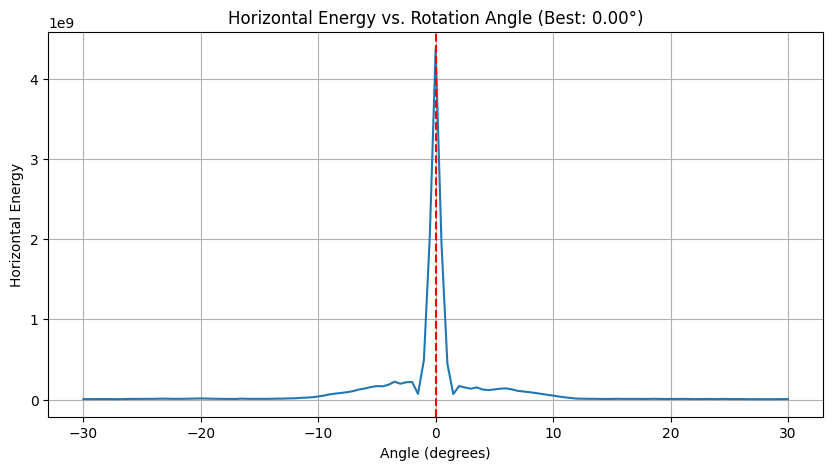

Final rotation: 0.00°
Detected text from horizontal image:

lorem ipsum dolor sit amet, consectetur adipiscing elit. nullam gravida vel metus vitae scelerisque. ut
quis augue eu erat bibendum egestas. sed a dui feugiat, pretium mi quis, fringilla quam. etiam hendrerit
quis leo non pulvinar. maecenas eleifend fringilla justo. cras aliquam auctor urna at facilisis. pellentesque
non egestas quam. sed mollis odio ac massa ornare porttitor. in sagittis dui eu hendrerit laoreet.
pellentesque ullamcorper gravida imperdiet. aliquam at purus sed ipsum consectetur porta id vel libero.
 
Match percentage: 99.8080614203455
Levenshtein Distance: 1



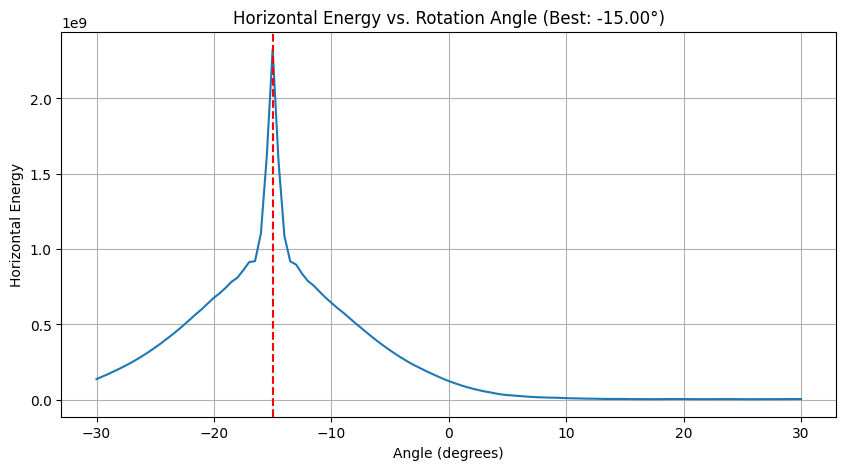

Final rotation: -15.00°
Detected text from rotated image:

 lorem ipsum dolor sit amet, consectetur adipiscing elit. nullam gravida vel metus vitae scelerisque. ut
 quis augue eu erat bibendum egestas. sed a dui feugiat, pretium mi quis, fringilla quam. etiam hendrerit
 quis leo non pulvinar. maecenas eleifend fringilla justo. cras aliquam auctor urna at facilisis. pellentesque
 non egestas quam. sed mollis odio ac massa ornare porttitor. in sagittis dui eu hendrerit laoreet.
 pellentesque ullamcorper gravida imperdiet. aliquam at purus sed ipsum consectetur porta id vel libero.
 
Match percentage: 98.84836852207293
Levenshtein Distance: 6


In [19]:
check_match_percent()